# Stock Market Data Project

## Fall Semester 2021
### Authors: Tanner Wallace, William Terry, Riley Gabrielson, Matthew Daw

## Introduction
>A quick Google search will tell you that the US Stock Market has been around since the late 18th century. Over the years, countless individuals have sought their fortunes in the market, experimenting with different trading strategies ranging from from the utterly bizarre to the purely quantitative. Even with thousands of academic papers detailing empirical studies, numerous anecodotal evidences, and countless trusted maxims, no one strategy has ever "solved" the market. However, as computing power has improved and data sets have grown, it is now easier to try out new strategies than ever before. With this context in mind, we now present our research question, and then give a brief literature review explaining the motivations behind our question.

## Research Question(s)
### Big Picture Question
>>**Do certain stocks move together in the market in such a way as to allow for successful portfolio construction around their joint movement?**

### Specific Questions to Answer
>>-  *How accurate are industry classifications at predicting joint movement?*
>>-  *Is there a better way to classify stocks that will give us more information to trade with?*
>>-  *How do we construct an optimal 'joint-movement' portfolio?*

##  A (Brief) Literature Review
>Much of the research done surrounding stock correlations has been done in the context of reducing risk. Understanding correlations between different stocks can allow an investor to hedge against downturns by investing in a portfolio with compensating correlations (i.e. one stock tends to go up as another goes down, thus protecting the investor from major losses). A 2011 study titled "Pairwise Comparisons" challenges this common perception of diversification by noting that correlations are often asymmetrical, meaning that as stock prices fall, the correlations are much stronger (i.e., stocks tend to fall together much more than rise together). This type of empirical descrepancy indicates that there is probably "dumb money" in the market, specifically with connection to relationships between stocks. Finding a way to accurately measure the covariance between specific stocks is a difficult task, but it may allow for more optimal portfolio construction.

>One common way of classifying the strength of these covariances comes from the Global Industry Classification System (GICS).The GICS is the market standard for classifying stocks into industry groups by granting each ticker an industry code.A recent paper title "Financial clusters, industry groups, and stock return correlations", explored how strongly these industry codes are correlated with stock returns. This 2021 article in the Journal of Financial Research challenged the accuracy of the GICS by instead classifying tickers based on the similarity of 10-K Financial statements to other tickers. The paper found that this method was effective, but that the most powerful model for explaining stock returns came by using this new financial clustering method in conjunction with the GICS instead of independent of the old method. This is encouraging research, and it motivates our hypothesis that there may be a more effective way of classifying stocks than using standard industry codes. This led us to formulating the research questions above.

## The Data
### Source:
>Our data comes from a database curated by Wharton of the Universty of Pennsylvania. There is a center there called the Center for Reseach of Security Prices (CRSP), which "maintains the most comprehensive collection of security price, return, and volume data for the NYSE, AMEX and NASDAQ stock markets" (https://wrds-www.wharton.upenn.edu/).

### Features:
>- Time-series stock price data from 2014-2021
>- 256 tickers queried at random from 81 distinct industries 
>- Industry code for each ticker, in a separate csv (since this is not time-series data)

### Data Querying Code:

In [8]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

>This code generates a list of random stocks to query from 20 industries, roughly evenly split across the industries
>This is important so that we have relatively robust classes to train any models on.
>Don't run this code again, we have already converted this info to a csv file.

In [4]:
# data = pd.read_csv('basic_stock_info.csv',index_col = 1)
# data.index = pd.to_datetime(data.index,format = '%Y%m%d')
# data.sort_index(inplace = True)
# data = data.loc[[data.index[0]]]
# data.reset_index(drop = True,inplace = True)
# data.set_index('PERMNO',inplace = True)
# data.dropna(how = 'any',inplace = True)


# industries = []
# for i in range(20):
#     random_industries = random.choices(tuple(set(data.NAICS)),k = 10)
#     rand_data = data[data['NAICS'].isin(random_industries)]
#     industries.append(rand_data[['TICKER','NAICS']].groupby('NAICS').count().idxmax()[0])
#     if len(set(industries)) == 10:
#         break

# data = data[data['NAICS'].isin(industries)]
# comps = list(data.index)
# comps = random.choices([int(n) for n in comps],k = 500)
# test = data.loc[data.index.isin(comps)]
# test.groupby('NAICS').count()
# np.savetxt('Comp_Codes.txt',comps,fmt = '%d')

## Cleaning and Augmentation
### Cleaning:
>We first must clean up the data file we queried from the CRSP database. This file contains the following features for every time step:

>- TICKER (Ticker)
>- PRC (Time-Series price data)
>- COMNAM (Expanded company name)
>- NAICS (North American Industry Classification System, i.e. Industry Code)



>We need to split this data into time-series data and static data. We map Ticker, Company Name, and Industry Code in one file and then split out time-series return data into another file so it will be easier to work with later on. Here is that code:

In [10]:
# This cell takes the csv we queried from CRSP and cleans it up. We then save it as a pair of 'cleaned'
# files called returns and stock_info, where returns is the time-series data and stock_info maps tickers to industry codes
# Don't run this cell again either, as it will overwrite these files.

# data = pd.read_csv('data.csv',index_col = 1)
# data.index = pd.to_datetime(data.index,format = '%Y%m%d')

# rets = data[['TICKER','PRC']]
# rets = pd.pivot_table(data[['TICKER','PRC']],index = rets.index,columns = 'TICKER')
# stock_info = data[['TICKER','COMNAM','NAICS']]
# stock_info.set_index('TICKER',inplace=True)
# stock_info['Industry_Code'] = stock_info['NAICS']
# stock_info['Company'] = stock_info['COMNAM']
# stock_info = stock_info[['Company','Industry_Code']]
# stock_info.drop_duplicates(inplace = True)

# #saving as 'clean' files
# rets.to_csv('returns.csv')
# stock_info.to_csv('stock_info.csv')

"This cell takes the csv we queried from CRSP and cleans it up. We then save it as a pair of 'cleaned'\nfiles called returns and stock_info, where returns is the time-series data and stock_info maps tickers to industry codes\nDon't run this cell again either, as it will overwrite these files."

### Augmentation: 
>Finally, we augment our returns file ('returns.csv') through the following steps:

>- Drop any NaN columns
>- Convert time-series closing prices into daily percent returns
>- 'Smooth' our data by calculating a monthly (22 trading day) and a weekly (5 trading day) rolling average dataframe
>- Save these new dataframes as csv files to make them easier to access


In [11]:
#read in returns file
df = pd.read_csv('returns.csv',index_col = 0)

#drop columns incomplete at any time-step
df.dropna(how = 'any',axis = 1,inplace = True)

#convert prices to percent returns
rets = df.pct_change().dropna(how = 'all',axis = 0)

#smooth out into rolling montly and weekly averages
monthly_rets = rets.rolling(window = 22).mean()
weekly_rets = rets.rolling(window = 5).mean()
yearly_rets = rets.rolling(window = 22*11).mean()

# #saving all changes as csv files (DON'T RUN THIS AGAIN)
# weekly_rets.to_csv('weekly_rets.csv')
# monthly_rets.to_csv('monthly_rets.csv')
# rets.to_csv('rets.csv')

## Exploratory Data Analysis (EDA)
>There are several different EDA techniques we will pursue here, but one of the most important is a simple validity check on our data. We want to make sure that the data we have queried makes sense. We can do this by displaying the cumulative market chart for all of the tickers we have queried. When we do this, using the returns.csv data from above, we get the following picture:

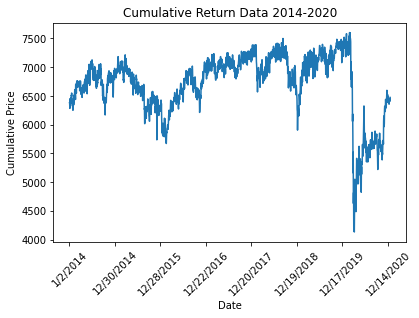

In [12]:
#Plot of all Prices as Check of Validity
plt.title("Cumulative Return Data 2014-2020")
df.sum(axis = 1).plot(xlabel = 'Date',ylabel = 'Cumulative Price')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

>This is a reasurring graphic, as we can see the things we expect to see. I.e. a slow build-up, and eventually the corona crash in early 2020. This means that our data is valid. It's also worth noting that the recovery from the crash wasn't as strong in our data as it was in the overall market. This probably indicates that in the industries we randomly chose earlier, we have some companies and industries that are more heavily affected by COVID. (most likely, tourism or airplanes).

#### Industry Codes

>We begin by inspecting the industry codes associated with their appropriate stocks.

![alt text](industry_dists.png "Stock Counts")

>We have 721 stocks with the appropriate industry codes, each with a years worth of historical stock data. The most common industry code is '525990.0' with 160 different stocks belonging to that industry. As shown above, one of the limitations of this dataset is that most industries have very few stocks.

>To illustrate how the different stocks are distributed by their returns, below are the returns for the 50th day of the data set, with each point colored by it's industry code.

![alt text](day_50_daily_rets.png "Stock Counts")

![alt text](day_50_weekly_rets.png "Stock Counts")

![alt text](day_50_monthly_rets.png "Stock Counts")

>We can see that the daily returns has a lot of variance, but the weekly and monthly rolling average returns smooth out the daily volatility and cluster closer together. We then approach fitting with Naive Bayes with this understanding, and expect monthly returns to be more representative of long term trends and thus better suited to predicting industry codes.


## Modeling

### Classification

>We start with some initial adjustments of the data to merge industry codes:

In [13]:
# weekly_returns = pd.read_csv('weekly_rets.csv')
# weekly_returns = weekly_returns.fillna(0)
# weekly_returns = weekly_returns.transpose()

# dates = weekly_returns.iloc[0].values
# modified_dates = [datetime.strptime(dates[i],'%m/%d/%Y').strftime('%b-%d-%Y') for i in range(len(dates))]

# weekly_returns.columns = modified_dates

# weekly_returns = weekly_returns.drop(['TICKER'])

# stock_info = pd.read_csv('stock_info.csv')
# stock_info = stock_info.set_index('TICKER')
# stock_info = stock_info.drop(columns=['Company'])

# joined = weekly_returns.join(stock_info, how='outer')
# joined = joined.dropna()
# joined["Industry_Code"] = joined["Industry_Code"].astype(str)

# data = joined.to_numpy();
# X_weekly_ret = data[:, :-1]
# y_weekly_ret = data[:, -1]

>Then we perform a simple Naive Bayes fitting and prediction:

In [1]:
# my_gnbc = GNBC()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# my_gnbc.fit(X_train, y_train)

# predictions = my_gnbc.predict(X_test)
# print("Naive Bayes Accuracy: " + str(sum(y_test == predictions) / len(predictions)))

> In order to test the validity of classifying stock data by industry codes, we attampted to use Logistic, Gaussian Naive Bayes, and Random Forest classifiers. We used Sklearn's implementations of these models as they are polished and easy to implement. For each model, we used a 7-fold cross validation to split the data into two partitions, one for actually training the model and the other for scoring it. The Naive Bayes classifier achieved no higher than 5-10% accuracy in each split which could be expected, since time-series data is not normally distributed.

### Portfolio Construction

For our model, we begin by taking out data and splitting it up into 15 time step chunks. For each of these chunks, we then look 8 time steps into the future and calculate an OLS regression off of it to get the average slope of the data which will serve as our y data point.

Using X and Y we can fit a a simple Sklearn Lasso model to predict the trend in the data. From our experiements, we were able to generate an average mean squared error of 0.000158 meaning we are quickly fitting relatively well. 

After this, we wished to estimate the variance of our model given each possible output. To do this, for each output we found the 20 outputs that were most similar to it, subtracted the true output values then calculated the variance of the resulting array. This generated the following graph:

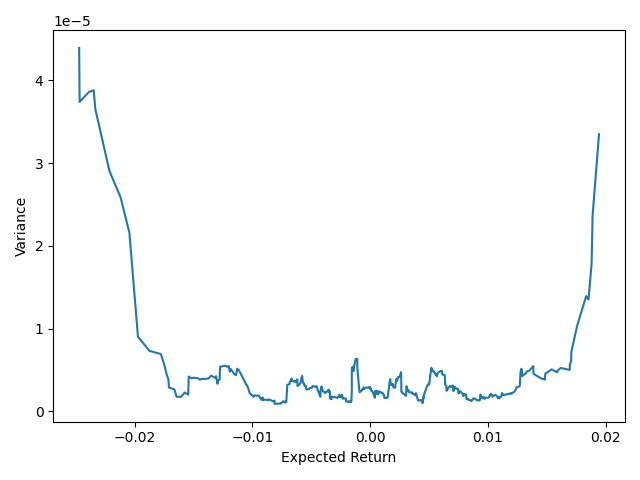

The grpah seems to indicate that the variance is largely uniform except for when the expected return is exceptionally high or low. This shouldn't be too surprising as the exterme outputs tend to be more sparse and require abnormal unpredicatible circumstances. 

We now have an algorithm that can output preditions and give a variance score for each of those different outputs. With this information, we have everything we need to use convex optimization to find the most idea porfolio setup. For that, we will be using python's cvxopt.

Let $x_i$ be the percentage we invest into a particular asset

Let $\hat{\sigma}_i$ be our estimated variance for a particular asset, note that $\sigma$ is a function of our predicted outward trend.

Let $\hat{y}$ be our estimates trend for a particular asset (this is the output of our OLS regression.

Let S be a minimum expected return we wish to generate.

We will be using the following constraints for our optimization:

Minimize $\sum (x_i\hat{\sigma}_i)^2$

Subject to $\sum x_i = 1$

Subject to $\sum x_i\hat{y} = S$

The main idea behind this optimization is that $\sum (x_i\hat{\sigma}_i)^2$ serves as the expect for a particular portfolio distribution. What we are effectively doing then is find an ideal balance between minimizing variance and maximizing expected returns. If we calculate the expected variance for various minimimal $S$ we end up with the following graph

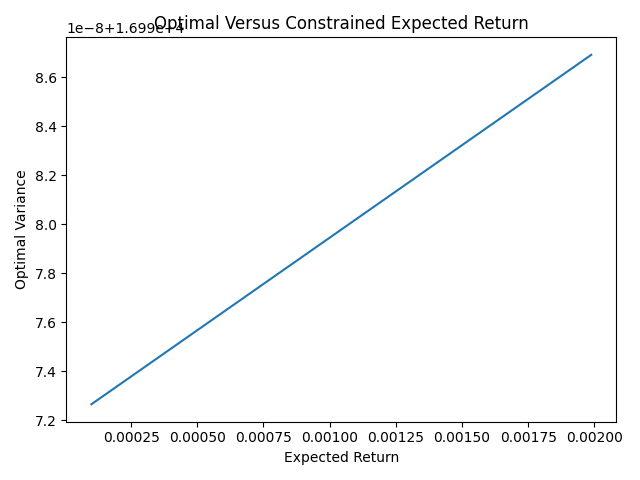


As we change minimum expected return we we can caclulate a porfolio distribution, and expected variance. By looking further in the data, we can also calculate the amount of money we would actually win with a given portfolio both in the short term (one time step) and long term (5 time steps). This generates the following results

## Results

### Classification

#### Naive Bayes

>Naive Bayes resulted in less than optimal, but very reasonable results in terms of accuracy.
>
>We begin by regressing on the raw daily closing prices, even though we do not expect closing prices to give useful information for us. This is because while we hope that industries will trend close to each other and increase and decrease together, we do not expect for example all oil stocks to typically fall in a certain range and all other stocks to fall outside that range. However, we investigate the possibility in the spirit of overpreparedness. The Naive Bayes Closing Prices Accuracy was 2.59%. While this result is better than randomly guessing industry codes, if our model instead simply guessed the most common industry code, we would have 27-35% accuracy.
>
>While regressing on daily, weekly, and monthly returns typically gave us slightly better results, we still were unable to get anywhere close to the accuracy of simply guessing the most common stock:
>
>Daily Returns Accuracy: 4.63%, 
>Weekly Returns Accuracy: 5.56%, 
>Monthly Accuracy: 3.70%, 

#### Other Regressions

>Surprisingly, the Logistic and Random Forest classifiers were able to accurately predict the industry codes of around 40-55% of each testing partition.
>
> Although these results may seem somewhat promising, this classification may not be useful. For example, the industry code '525990' accounts for nearly 40% of our data with no other industry code account for more than 10% of the total data, so a classifier that merely assigns all samples to this most common class would be expected to roughly achieve 30-40% accuracy, which makes even our best classifier little better than this most common class model. 
>
> This industry code distribution was also an issue when attempting a binary classification. Because the vast majority of industry codes account for less than ten percent of the total dataset, an attempt to classify the data soley on whether or not a sample is in that specific industry will learn to classify everything as outside of the industry and still achieve over 90%, which gives us no useful information.

### Portfolio Construction

As we change minimum expected return we we can caclulate a porfolio distribution, and expected variance. By
looking further in the data, we can also calculate the amount of money we would actually win with a given
portfolio both in the short term (one time step) and long term (5 time steps). This generates the following results:

The most optimal point in respect to short term is:

![alt text](short_term_optimal.png "Stock Counts")

The most optimal point in respect to long term is:

![alt text](long_term_optimal.png "Stock Counts")


## Ethical Considerations
> Although the ethical ramifications of any kind of quantitative modeling are important to consider, this is the rare project that offers no immediate areas to be concerned about. There are however a few things to consider. First of all, we need to be sure that in reporting on our work here, we are reporting fair and accurate results. There is a natural tendency to hope for a successful model; this tendency is perhaps even stronger in a space as competitive and zero-sum as the US Stock Market. Because this is such a competitive space, it is vital that we are careful to use only data that we should have access to when we should have access to it. For example, since stock data is largely time-series information, we need to be careful that any models we build rely only on data at previous points in time. Building a model based on current (or even future!) data will certainly be more accurate, but it will also yield dishonest results.

>One other important ethical point is that we need to make sure not to misrepresent what this project is. This is not investment advice nor is it fully fleshed out. This is a half-baked attempt at modeling one potential stock market trading strategy. In order to be able to fully endorse this as an investment strategy, we would need much more testing and experimentation. (And qualifications).

## Suggestions for Further Research
>We have three suggestions for further research.
>- Try more models and methods of classifying stocks into groups. As mentioned, one of the papers above found the best success combining several methods. Trying different models together (and being careful with collinearity problems) should hopefully yield better results. 
>- Experiment with better ways to turn the correlations we do find into an optimal portfolio. In particular, experimenting with different time horizons and different buy/sell signals could yield fascinating results. These ideas will need to implemented, back-tested, and checked for robustness. 
>- Finally, more research should be done regarding what causes stocks to move together. For this project, we have been largely concerned with identifying correlative movement, but less focused on why these movements are happening. Being able to identify a causal hypothesis will yield to more robust models in all phases of this type of research.

## Sources